In [3]:
from IPython import display

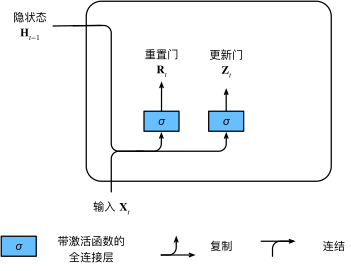

In [4]:
display.SVG('imgs/gru_gates.svg')

\begin{split}\begin{aligned}
\mathbf{R}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xr} + \mathbf{H}_{t-1} \mathbf{W}_{hr} + \mathbf{b}_r)\\
\mathbf{Z}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xz} + \mathbf{H}_{t-1} \mathbf{W}_{hz} + \mathbf{b}_z)
\end{aligned}\end{split} 

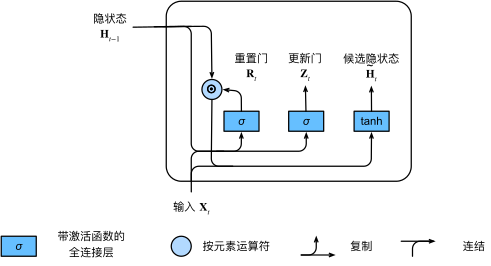

In [5]:
display.SVG('imgs/gru_hidden_candidate.svg')

\begin{split}\begin{aligned}
    \tilde{\mathbf{H}}_t = \tanh(\mathbf{X}_t \mathbf{W}_{xh} + \left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{hh} + \mathbf{b}_h),
\end{aligned}\end{split} 

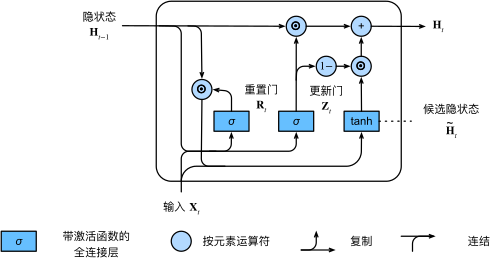

In [6]:
display.SVG('imgs/gru_hidden.svg')

\begin{split}\begin{aligned}
    \mathbf{H}_t = \mathbf{Z}_t \odot \mathbf{H}_{t-1}  + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t
\end{aligned}\end{split} 

In [7]:
import torch
from torch import nn
from d2l import torch as d2l

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
def init_params(vocab_size, num_hiddens, device):
    num_inputs = vocab_size
    num_outputs = vocab_size
    
    ### Gaussian distribution for initialization
    def gate_params():
        return (
            torch.randn(size=(num_inputs, num_hiddens), device=device) * 0.01,
            torch.randn(size=(num_hiddens, num_hiddens), device=device) * 0.01,
            torch.zeros(num_hiddens, device=device)
        )
        
    # 1. Update gate params
    W_xz, W_hz, b_z = gate_params() 
    
    # 2. Reset gate params
    W_xr, W_hr, b_r = gate_params() 
    
    # 3. Candidate hidden state params
    W_xh, W_hh, b_h = gate_params()
    
    # 4. Output layer params
    W_hq = torch.randn(size=(num_hiddens, num_outputs), device=device) * 0.01
    b_q = torch.zeros(num_outputs, device=device)
    
    ### Initialize gradient of all parameters
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for p in params:
        p.requires_grad_(True)
    return params

In [16]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros(size=(batch_size, num_hiddens), device=device), )

In [17]:
def gru(inputs, state, params):
    ### Initialize parameters
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    
    ### Compute the predition 
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_h = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_h
        Y = H @ W_hq + b_q
        outputs.append(Y)
    
    return torch.cat(outputs, dim=0), (H,) 

In [18]:
batch_size = 32
num_steps = 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [19]:
vocab_size = len(vocab)
num_hiddens = 256
model = d2l.RNNModelScratch(vocab_size, num_hiddens, device,
                            init_params, init_gru_state, gru)

perplexity 1.1, 27476.8 tokens/sec on cuda
time traveller time back lorgrimestmons hat that mane his said t
traveller but you cannot get away from thepresent momentmy 


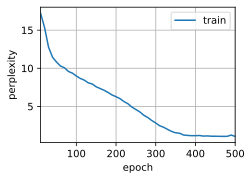

In [20]:
EPOCHS = 500
LR = 1

d2l.train_ch8(model, train_iter, vocab, LR, EPOCHS, device)

perplexity 1.0, 120847.3 tokens/sec on cuda
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


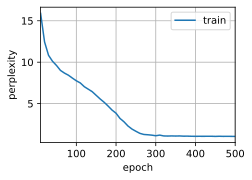

In [21]:
# A quick iplementation using torch
gru_layer = nn.GRU(vocab_size, num_hiddens)
model = d2l.RNNModel(gru_layer, vocab_size)
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, LR, EPOCHS, device)